In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_all = pd.read_pickle('final_cleaned_df.pkl')  # Or however you've saved it

amzn_df = df_all.xs('AMZN', level='Ticker').copy()

# Drop rows with NaNs (especially at beginning of moving averages)
amzn_df.dropna(inplace=True)

In [5]:
split_idx = int(len(amzn_df) * 0.8)
amzn_train = amzn_df.iloc[:split_idx]
amzn_test  = amzn_df.iloc[split_idx:]

In [8]:
X_lr, y_lr = [], []
close_series = amzn_df['Close'].values
for i in range(5, len(amzn_df)):
    X_lr.append(close_series[i-5:i])
    y_lr.append(close_series[i])
X_lr, y_lr = np.array(X_lr), np.array(y_lr)

X_lr_train = X_lr[:split_idx-5]
y_lr_train = y_lr[:split_idx-5]
X_lr_test = X_lr[split_idx-5:]
y_lr_test = y_lr[split_idx-5:]

model_lr = LinearRegression()
model_lr.fit(X_lr_train, y_lr_train)
pred_lr = model_lr.predict(X_lr_test)

mae_lr = mean_absolute_error(y_lr_test, pred_lr)
print(mae_lr)

7.924696781297293


In [10]:
model_arima = ARIMA(amzn_train['Close'], order=(5, 1, 0))
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.forecast(steps=len(amzn_test))

mae_arima = mean_absolute_error(amzn_test['Close'], pred_arima)
mae_arima

158.59334476109828

In [11]:
features = ['MA7', 'MA30', 'Daily Return', 'Volatility30']
X_rf = amzn_df[features]
y_rf = amzn_df['Close']

X_rf_train = X_rf.iloc[:split_idx]
y_rf_train = y_rf.iloc[:split_idx]
X_rf_test = X_rf.iloc[split_idx:]
y_rf_test = y_rf.iloc[split_idx:]

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_rf_train, y_rf_train)
pred_rf = model_rf.predict(X_rf_test)

mae_rf = mean_absolute_error(y_rf_test, pred_rf)
mae_rf

155.13954042145588

In [12]:
print("\n--- Mean Absolute Errors ---")
print(f"Linear Regression: {mae_lr:.4f}")
print(f"ARIMA: {mae_arima:.4f}")
print(f"Random Forest: {mae_rf:.4f}")



--- Mean Absolute Errors ---
Linear Regression: 7.9247
ARIMA: 158.5933
Random Forest: 155.1395


In [22]:
best_model = min((mae_lr, 'Linear Regression'), (mae_arima, 'ARIMA'), (mae_rf, 'Random Forest'))
print(f"\n Best Model: {best_model[1]} (MAE = {best_model[0]:.4f})")


 Best Model: Linear Regression (MAE = 7.9247)


Length of dates_for_plot: 516
Length of cumulative_profit: 521


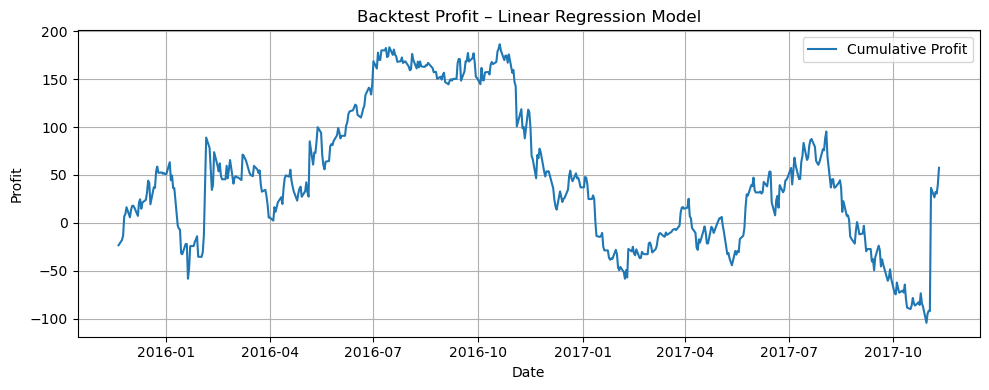


 Total Hypothetical Profit over test period: 57.51


In [23]:
# ─────────────────────────────────────────────
# 💰 Backtesting the Best Model (Linear Regression)
# ─────────────────────────────────────────────
# Generate signals: Buy if predicted > current
signal = np.where(pred_lr > y_lr_test, 1, -1)  # 1 = Buy, -1 = Sell
returns = np.diff(y_lr_test)  # Price difference each day
signals = signal[:-1]         # Align signals to returns
profit = signals * returns

# Cumulative profit
cumulative_profit = np.cumsum(profit)

# Align dates for plotting (skip first day due to diff)
test_dates = amzn_df.index[split_idx + 5:]  # offset by 5 for lag
dates_for_plot = test_dates[1:1 + len(cumulative_profit)]

# Debug: Check lengths before plotting
print(f"Length of dates_for_plot: {len(dates_for_plot)}")
print(f"Length of cumulative_profit: {len(cumulative_profit)}")

# Make sure dates_for_plot and cumulative_profit have the same length
# Use the minimum length to ensure they match
min_length = min(len(dates_for_plot), len(cumulative_profit))
dates_for_plot = dates_for_plot[:min_length]
cumulative_profit = cumulative_profit[:min_length]

# Plot profit
plt.figure(figsize=(10, 4))
plt.plot(dates_for_plot, cumulative_profit, label='Cumulative Profit')
plt.title("Backtest Profit – Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final PnL
print(f"\n Total Hypothetical Profit over test period: {cumulative_profit[-1]:.2f}")